In [1]:
import numpy as np
import torch 
import torchvision 
import torchaudio
import torch.nn as nn
import math
import torch.nn.functional as F
from Jaguas_DataLoader import SoundscapeData
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import random_split
!pip install positional-encodings[pytorch]
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer, PositionalEncodingPermute2D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!pip install wandb --upgrade
!wandb login
import wandb
wandb.login()

wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


True

In [2]:
p_enc_2d = PositionalEncodingPermute2D(5)
y = torch.zeros((1,6,2,8))
print(p_enc_2d(y).shape) # (1, 6, 2, 8)
p_enc_2d(y)

torch.Size([1, 6, 2, 8])


tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000],
          [ 0.8415,  0.8415,  0.8415,  0.8415,  0.8415,  0.8415,  0.8415,
            0.8415]],

         [[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
            1.0000],
          [ 0.5403,  0.5403,  0.5403,  0.5403,  0.5403,  0.5403,  0.5403,
            0.5403]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000],
          [ 0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100,
            0.0100]],

         [[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
            1.0000],
          [ 0.9999,  0.9999,  0.9999,  0.9999,  0.9999,  0.9999,  0.9999,
            0.9999]],

         [[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,
            0.6570],
          [ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,
            0.6570]],

         [[ 1.0000,  0.5403, -0.4161, -0

In [10]:
class PositionalEncoding2d(nn.Module):

    def __init__(self, d_model: int=64, height: int = 9, width: int =9, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)
        
    def forward(self, x, index: int, dropout: bool=False):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x.to("cuda")
        self.pe = self.pe.to("cuda")
#         print(x.shape, self.pe.shape)
        x = x + self.pe[index]
        if dropout:
            x = self.dropout(x)
        else:
            x = x
        return x

In [28]:
class posautoencoding_m1(nn.Module):

    """
    Convolutional autoencoder made to reconstruct the audios spectrograms generated by the EcoDataTesis dataloader.
    """

    def __init__(self, num_hiddens: int=64):
        """
        Constructor of the convolutional autoencoder model.
        """
        super().__init__()
        # TODO: To design the final architechture considering the spectrograms sizes.
        # TODO: To correct the current sizes of the decoder.

        self.encoder = nn.Sequential(
            nn.Conv2d(1, num_hiddens // 8, kernel_size=8, stride=3, padding=0),  # N, 256, 127, 8004
            nn.ReLU(),
            nn.Conv2d(num_hiddens // 8, num_hiddens // 4, kernel_size=8, stride=3, padding=0),  # N, 512, 125,969
            nn.ReLU(),
            nn.Conv2d(num_hiddens // 4, num_hiddens // 2, kernel_size=4, stride=3, padding=0),  # N, 512, 125,969
            nn.ReLU(),
            nn.Conv2d(num_hiddens // 2, num_hiddens, kernel_size=2, stride=2, padding=0),  # N, 512, 125,969
            nn.ReLU()
             )
        self.decoder = nn.Sequential(  # This is like go in opposite direction respect the encoder
            nn.ConvTranspose2d(num_hiddens, num_hiddens // 2, kernel_size=2, stride=2, padding=0, output_padding=0),  # N, 32, 126,8000
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=4, stride=3, padding=0, output_padding=0),  # N, 32, 127,64248
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens // 4, num_hiddens // 8, kernel_size=8, stride=3, padding=0, output_padding=0),  # N, 32, 127,64248
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens // 8, 1, kernel_size=8, stride=3, padding=0, output_padding=0),  # N, 32, 127,64248
            nn.Sigmoid()
             )
            
#         self.posencoding = PositionalEncodingPermute2D(5)
            
            
    def forward(self, x, y):
        
        """
        Method to compute an image output based on the performed model.

        :param x: Input spectrogram images as tensors.
        :type x: torch.tensor
        :return: Reconstructed images
        """
        
        #print(f"x_shape:{x.shape}")
        encoded = self.encoder(x)
#         print("encoded: ", encoded.shape)
        pos_encoder = PositionalEncoding2d(64, dropout = 0.1, max_len = 20).to("cuda")
        posencoding_2d = pos_encoder(encoded.permute(1,0,2,3), y)
#         print(posencoding_2d)
        posencoding_2d = posencoding_2d.permute(1,0,2,3)
#         print("encoder_shape: ", encoded.shape)
        decoded = self.decoder(posencoding_2d)
#         print("decoder_shape: ",decoded.shape)
        return decoded

In [29]:
root_path = 'media/mirp_ai/DATA1/Jaguas_2018'
dataset = SoundscapeData(root_path, audio_length=12, ext="wav", win_length=1028)
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.7), len(dataset) - round(len(dataset)*0.7)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "project" : "positionalAE-Jaguas",
    "audio_length": dataset.audio_length,
    "batch_size" : 14,
    "num_epochs": 3,
    "num_hiddens" : 64,
    "gamma_lr" : 0.1,
    "learning_rate" : 1e-3,
    "dataset" : "Audios Jaguas",
    "architecture": "PositionalAE",
    "win_length" : dataset.win_length
}

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])

model = posautoencoding_m1(num_hiddens=config["num_hiddens"]).to("cuda")

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 6, gamma = config["gamma_lr"] )

config["optimizer"] = optimizer
config["scheduler"] = scheduler
config["num_training_updates"] = len(training_loader)

/media/mirp_ai/DATA1/Jaguas_2018


In [30]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
class TestModel:
    """
            Class to test convolutional autoencoder models.

    """

    """

            :param index: index indicates the number of data to return.
            :returns:
                :spec: Spectrogram of the indexed audios.
                :type spec: torch.tensor
                :record: Array of indexed audios in monophonic format.
                :type record: numpy.array
                :label: Dictionary of labels including recorder, hour, minute and second keys.
                :type label: Dictionary
                :path_index: File directory.
                :type path index: String

    """

    def __init__(self, model, iterator, num_views=8, device="cuda"):

        """
            :param model: Deep learning model.
            :type model:
            :param iterator: dataloader iterator.
            :type iterator:
            :param num_views: Specify the number of samples to visualize previously and after the reconstruction.
            :type num_views:
            :param device: Specify the device to do calculus.
            :type device:
            Todo:
                Check the args type.
            """

        self._model = model
        self._iterator = iterator
        self.num_views = num_views
        self.device = device
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def save_waveform(self, waveform, directory=None):
        scaled = np.int16(waveform[0, 0] / np.max(np.abs(waveform[0, 0])) * 32767)
        write(directory + '.wav', 22050, scaled)

    def plot_waveform(self, waveform, n_rows=4):
        fig, axs = plt.subplots(n_rows, figsize=(10, 6), constrained_layout=True)
        for i in range(n_rows):
            axs[i].plot(waveform[i, 0])
        plt.show()

    def waveform_generator(self, spec, n_fft=1028, win_length=1028, audio_length=12, base_win=256):
        spec = spec.cdouble()
        spec = spec.to("cpu")
        # hop_length = int(np.round(base_win/win_length * 172.3))
        transformation = audio_transform.InverseSpectrogram(n_fft=n_fft, win_length=win_length)
        waveform = transformation(spec)
        waveform = waveform.cpu().detach().numpy()
        return waveform

    def plot_psd(self, waveform, n_wavs=1):
        for i in range(n_wavs):
            plt.psd(waveform[i][0])
            plt.xlabel("Frequency", fontsize=16)
            plt.ylabel("Power Spectral Density", fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)

    def plot_reconstructions(self, imgs_original, imgs_reconstruction):
        output = torch.cat((imgs_original[0:self.num_views], imgs_reconstruction[0:self.num_views]), 0)
        img_grid = make_grid(output, nrow=self.num_views, pad_value=20)
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.imshow(img_grid[1, :, :].cpu(), origin="lower", vmin=0, vmax=1)
        ax.axis("off")
        plt.show()
        return fig

    def reconstruct(self):
        self._model.eval()
        (valid_originals, _, label, path) = next(self._iterator)
        valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1]
                                                          * valid_originals.shape[2], valid_originals.shape[3],
                                                          valid_originals.shape[4]))
        valid_originals = torch.unsqueeze(valid_originals, 1)
        valid_originals = valid_originals.to(self.device)

        valid_encodings = self._model.encoder(valid_originals)

        valid_reconstructions = self._model.decoder(valid_encodings)

        valid_originals_nonorm = torch.expm1(valid_originals)
        valid_reconstructions_nonorm = torch.expm1(valid_reconstructions)

        BCE = F.mse_loss(valid_reconstructions, valid_originals)
        loss = BCE

        return valid_originals, valid_reconstructions, valid_encodings, label, loss, path

In [31]:
from six.moves import xrange
class TrainModel:

    def __init__(self, model):
        self._model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._model.to(self.device)
        print(self.device)
        
    def wandb_init(self, config, keys=["batch_size", "num_hiddens"]):
        try:
            run_name = str(config["architecture"]+"_")
            for key in keys:
                if key in config.keys():
                    run_name = run_name + key + "_" + str(config[key]) + "_"
                else:
                    run_name = run_name + str(key)

            wandb.login()
            wandb.finish()
            wandb.init(project="AE-Jaguas", config=config)
            wandb.run.name = run_name
            wandb.run.save()
            wandb.watch(self._model, F.mse_loss, log="all", log_freq=1)
            is_wandb_enable = True
        except Exception as e:
            print(e)
            is_wandb_enable = False

        return is_wandb_enable, run_name

    def wandb_logging(self, dict):
        for keys in dict:
            wandb.log({keys: dict[keys]})


    def forward(self, training_loader, test_loader, config):
        iterator = iter(test_loader)
        wandb_enable, run_name = self.wandb_init(config)
        optimizer = config["optimizer"]
        scheduler = config["scheduler"]
        
        logs = []
        # best_loss = 10000

        for epoch in range(config["num_epochs"]):
            iterator_train = iter(training_loader)
            for i in xrange(config["num_training_updates"]):
                self._model.train()
                try:
                    data, _, label, _ = next(iterator_train)
                except Exception as e:
                    print("error")
                    print(e)
                    logs.append(e)
                    continue

                data = torch.reshape(data, (data.shape[0] * data.shape[1] * data.shape[2], data.shape[3], data.shape[4]))
                data = torch.unsqueeze(data, 1)
                data = data.to("cuda")

                optimizer.zero_grad()
                data_recon = self._model(data, label["recorder"].reshape(14*5))

                loss = F.mse_loss(data_recon, data)
                loss.backward()

                optimizer.step()
                print(
                    f'epoch: {epoch + 1} of {config["num_epochs"]} \t iteration: {(i + 1)} of {config["num_training_updates"]} \t loss: {np.round(loss.item(), 4)}')
                dict = {"loss": loss.item()}
                self.wandb_logging(dict)
                
                if (i + 1) % 20 == 0:
                    try:
                        test_ = TestModel(self._model, iterator, 8, device=torch.device("cuda"))
                        # torch.save(model.state_dict(),f'model_{epoch}_{i}.pkl')
                        originals, reconstructions, encodings, labels, test_error, path = test_.reconstruct()
                        fig = test_.plot_reconstructions(originals, reconstructions)
                        images = wandb.Image(fig, caption=f"recon_error: {np.round(test_error.item(), 4)}")
                        self.wandb_logging({"examples": images, "step": (i + 1) // 20})

                    except Exception as e:
                        print(f"error; {e}")
                        logs.append(e)
                        continue
                else:
                    pass

                if loss < 0.04:
                    # wandb.alert(
                    #     title='High accuracy',
                    #     text=f'Recon error {loss} is lower than 0.04',
                    #     level=AlertLevel.WARN,
                    #     wait_duration=timedelta(minutes=1)
                    # )
                    time = datetime.datetime.now()
                    torch.save(self._model.state_dict(), f'{run_name}_day_{time.day}_hour_{time.hour}_low_error.pkl')
                else:
                    pass

            scheduler.step()
            torch.cuda.empty_cache()
            time = datetime.datetime.now()
            torch.save(self._model.state_dict(), f'{run_name}_day_{time.day}_hour_{time.hour}_epoch_{epoch + 1}.pkl')
            clear_output()
            print(optimizer.state_dict()["param_groups"][0]["lr"])

        wandb.finish()
        return self._model, logs, run_name

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


cuda


loss,▁▁█
loss,0.54098


epoch: 1 of 3 	 iteration: 1 of 1004 	 loss: 0.3725
epoch: 1 of 3 	 iteration: 2 of 1004 	 loss: 0.378
epoch: 1 of 3 	 iteration: 3 of 1004 	 loss: 0.5508
epoch: 1 of 3 	 iteration: 4 of 1004 	 loss: 0.4386
epoch: 1 of 3 	 iteration: 5 of 1004 	 loss: 0.8135
epoch: 1 of 3 	 iteration: 6 of 1004 	 loss: 0.5797
epoch: 1 of 3 	 iteration: 7 of 1004 	 loss: 0.3665
epoch: 1 of 3 	 iteration: 8 of 1004 	 loss: 0.3553
epoch: 1 of 3 	 iteration: 9 of 1004 	 loss: 0.337
epoch: 1 of 3 	 iteration: 10 of 1004 	 loss: 0.5228
epoch: 1 of 3 	 iteration: 11 of 1004 	 loss: 0.5461
epoch: 1 of 3 	 iteration: 12 of 1004 	 loss: 0.4423
epoch: 1 of 3 	 iteration: 13 of 1004 	 loss: 0.4596
epoch: 1 of 3 	 iteration: 14 of 1004 	 loss: 0.4305
epoch: 1 of 3 	 iteration: 15 of 1004 	 loss: 0.383
epoch: 1 of 3 	 iteration: 16 of 1004 	 loss: 0.3957
epoch: 1 of 3 	 iteration: 17 of 1004 	 loss: 0.4766
epoch: 1 of 3 	 iteration: 18 of 1004 	 loss: 0.3376
epoch: 1 of 3 	 iteration: 19 of 1004 	 loss: 0.429
epoch:

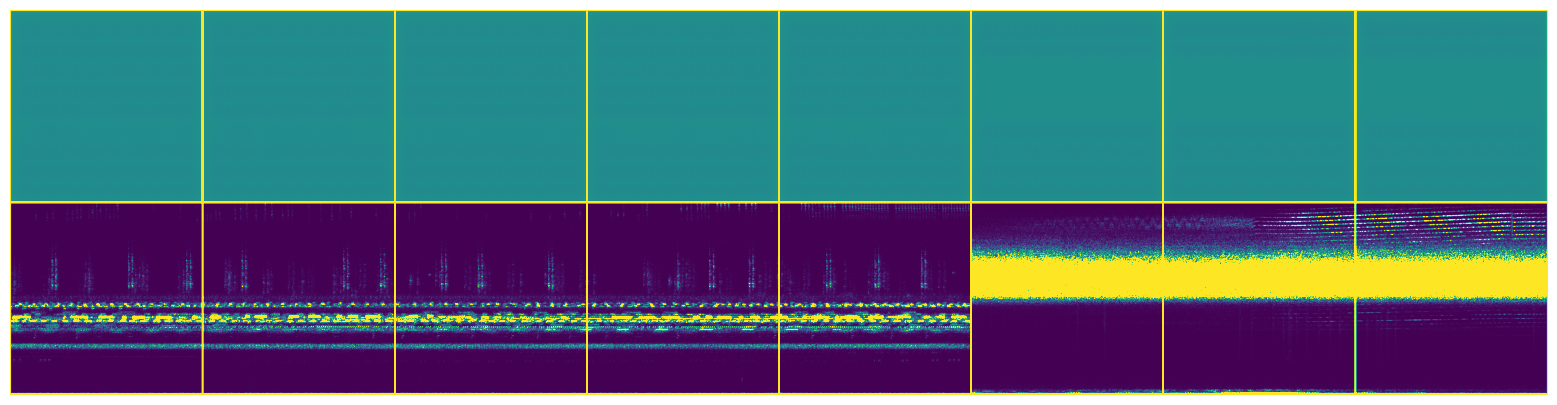

epoch: 1 of 3 	 iteration: 21 of 1004 	 loss: 0.3864
epoch: 1 of 3 	 iteration: 22 of 1004 	 loss: 0.3195
epoch: 1 of 3 	 iteration: 23 of 1004 	 loss: 0.2473
epoch: 1 of 3 	 iteration: 24 of 1004 	 loss: 0.3358
epoch: 1 of 3 	 iteration: 25 of 1004 	 loss: 0.2176
epoch: 1 of 3 	 iteration: 26 of 1004 	 loss: 0.3148
epoch: 1 of 3 	 iteration: 27 of 1004 	 loss: 0.4124
epoch: 1 of 3 	 iteration: 28 of 1004 	 loss: 0.7221
epoch: 1 of 3 	 iteration: 29 of 1004 	 loss: 0.3483
epoch: 1 of 3 	 iteration: 30 of 1004 	 loss: 0.3951
epoch: 1 of 3 	 iteration: 31 of 1004 	 loss: 0.4202
epoch: 1 of 3 	 iteration: 32 of 1004 	 loss: 0.4565
epoch: 1 of 3 	 iteration: 33 of 1004 	 loss: 0.365
epoch: 1 of 3 	 iteration: 34 of 1004 	 loss: 0.4487
epoch: 1 of 3 	 iteration: 35 of 1004 	 loss: 0.292
epoch: 1 of 3 	 iteration: 36 of 1004 	 loss: 0.1723
epoch: 1 of 3 	 iteration: 37 of 1004 	 loss: 0.3631
epoch: 1 of 3 	 iteration: 38 of 1004 	 loss: 0.1933
epoch: 1 of 3 	 iteration: 39 of 1004 	 loss: 0.

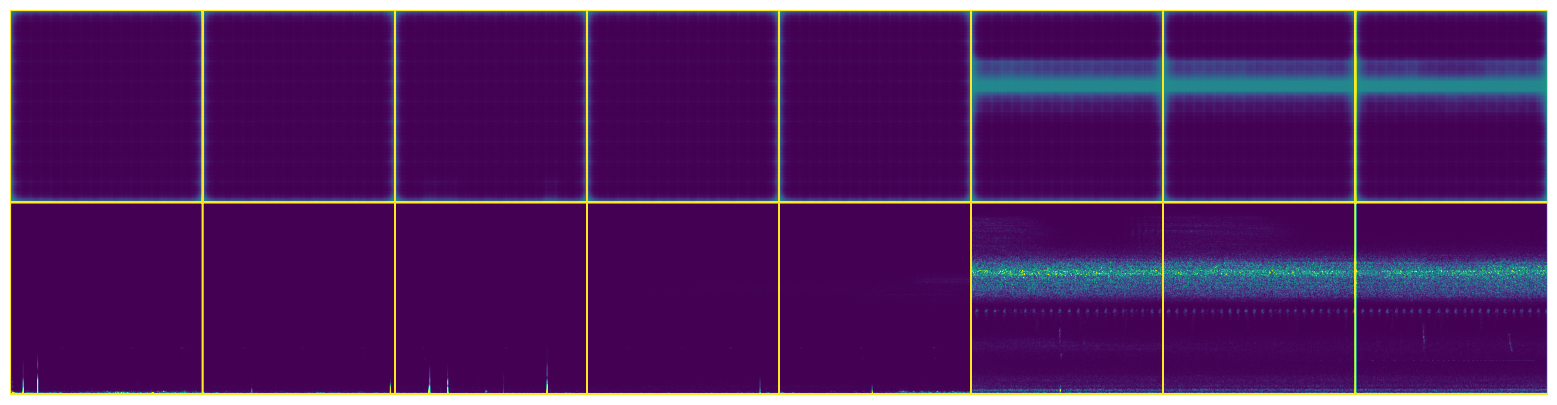

epoch: 1 of 3 	 iteration: 41 of 1004 	 loss: 0.3258
epoch: 1 of 3 	 iteration: 42 of 1004 	 loss: 0.4478
epoch: 1 of 3 	 iteration: 43 of 1004 	 loss: 0.3488
epoch: 1 of 3 	 iteration: 44 of 1004 	 loss: 0.52
epoch: 1 of 3 	 iteration: 45 of 1004 	 loss: 0.358
epoch: 1 of 3 	 iteration: 46 of 1004 	 loss: 0.2305
epoch: 1 of 3 	 iteration: 47 of 1004 	 loss: 0.4035
epoch: 1 of 3 	 iteration: 48 of 1004 	 loss: 0.3134
epoch: 1 of 3 	 iteration: 49 of 1004 	 loss: 0.2994
epoch: 1 of 3 	 iteration: 50 of 1004 	 loss: 0.6077
epoch: 1 of 3 	 iteration: 51 of 1004 	 loss: 0.2034
epoch: 1 of 3 	 iteration: 52 of 1004 	 loss: 0.2714
epoch: 1 of 3 	 iteration: 53 of 1004 	 loss: 0.1722
epoch: 1 of 3 	 iteration: 54 of 1004 	 loss: 0.3467
epoch: 1 of 3 	 iteration: 55 of 1004 	 loss: 0.3198
epoch: 1 of 3 	 iteration: 56 of 1004 	 loss: 0.1494
epoch: 1 of 3 	 iteration: 57 of 1004 	 loss: 0.3507
epoch: 1 of 3 	 iteration: 58 of 1004 	 loss: 0.379
epoch: 1 of 3 	 iteration: 59 of 1004 	 loss: 0.17

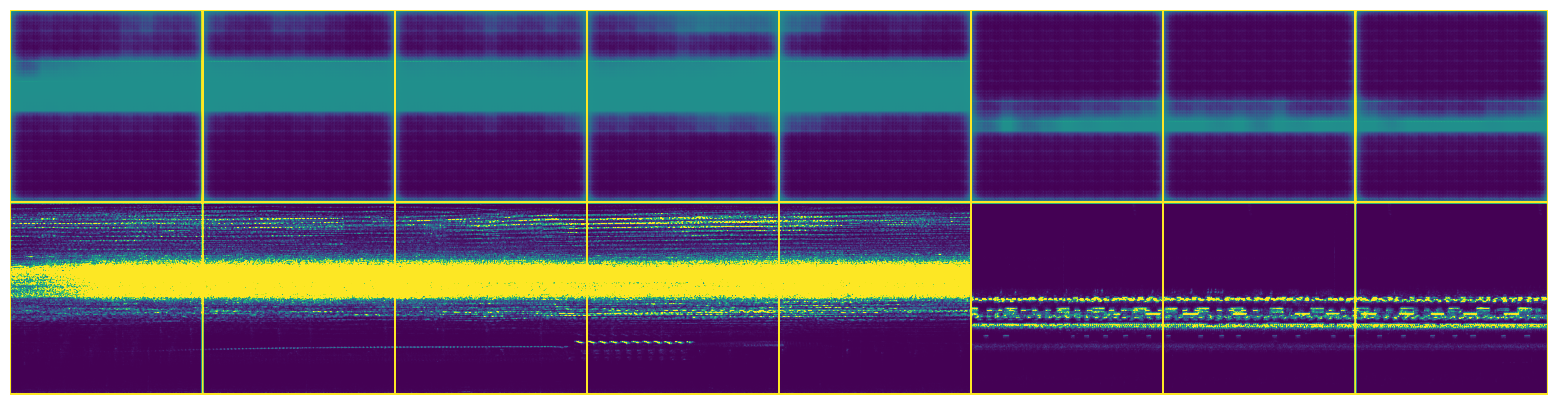

epoch: 1 of 3 	 iteration: 61 of 1004 	 loss: 0.281
epoch: 1 of 3 	 iteration: 62 of 1004 	 loss: 0.2521
epoch: 1 of 3 	 iteration: 63 of 1004 	 loss: 0.1596
epoch: 1 of 3 	 iteration: 64 of 1004 	 loss: 0.2256
epoch: 1 of 3 	 iteration: 65 of 1004 	 loss: 0.2902
epoch: 1 of 3 	 iteration: 66 of 1004 	 loss: 0.154
epoch: 1 of 3 	 iteration: 67 of 1004 	 loss: 0.2723
epoch: 1 of 3 	 iteration: 68 of 1004 	 loss: 0.1245
epoch: 1 of 3 	 iteration: 69 of 1004 	 loss: 0.2501
epoch: 1 of 3 	 iteration: 70 of 1004 	 loss: 0.4789
epoch: 1 of 3 	 iteration: 71 of 1004 	 loss: 0.547
epoch: 1 of 3 	 iteration: 72 of 1004 	 loss: 0.3001
epoch: 1 of 3 	 iteration: 73 of 1004 	 loss: 0.1421
epoch: 1 of 3 	 iteration: 74 of 1004 	 loss: 0.2007
epoch: 1 of 3 	 iteration: 75 of 1004 	 loss: 0.247
epoch: 1 of 3 	 iteration: 76 of 1004 	 loss: 0.2542
epoch: 1 of 3 	 iteration: 77 of 1004 	 loss: 0.4617
epoch: 1 of 3 	 iteration: 78 of 1004 	 loss: 0.3649
epoch: 1 of 3 	 iteration: 79 of 1004 	 loss: 0.19

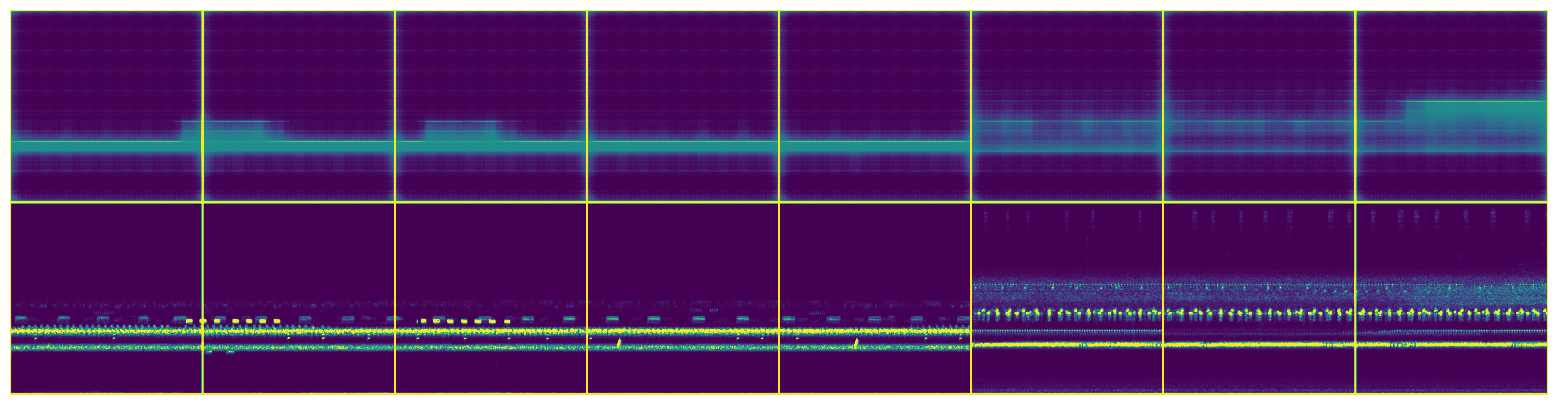

epoch: 1 of 3 	 iteration: 81 of 1004 	 loss: 0.2951
epoch: 1 of 3 	 iteration: 82 of 1004 	 loss: 0.3549
epoch: 1 of 3 	 iteration: 83 of 1004 	 loss: 0.2459
epoch: 1 of 3 	 iteration: 84 of 1004 	 loss: 0.232
epoch: 1 of 3 	 iteration: 85 of 1004 	 loss: 0.2545
epoch: 1 of 3 	 iteration: 86 of 1004 	 loss: 0.3727
epoch: 1 of 3 	 iteration: 87 of 1004 	 loss: 0.1902
epoch: 1 of 3 	 iteration: 88 of 1004 	 loss: 0.1444
epoch: 1 of 3 	 iteration: 89 of 1004 	 loss: 0.3282
epoch: 1 of 3 	 iteration: 90 of 1004 	 loss: 0.155
epoch: 1 of 3 	 iteration: 91 of 1004 	 loss: 0.1862
epoch: 1 of 3 	 iteration: 92 of 1004 	 loss: 0.3347


In [ ]:
Training = TrainModel(model=model.to("cuda"))
model, logs, run_name = Training.forward(training_loader, test_loader, config)
time = datetime.datetime.now()
torch.save(model.state_dict(),f'temporal/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth')
torch.save(config,f'temporal/configs/config_{run_name}_day_{time.day}_hour_{time.hour}.pth')
torch.save(dataset_test, f"temporal/datasets/dataset_test_posae_jaguas_{time.day}_70%.pth")
torch.save(dataset_train, f"temporal/datasets/dataset_train_posae_jaguas_{time.day}_70%.pth")

In [ ]:
iterador = iter(training_loader)
data, b, c, d = next(iterador)
data = torch.reshape(data, (data.shape[0] * data.shape[1] * data.shape[2], data.shape[3], data.shape[4]))
data = torch.unsqueeze(data, 1)
data.shape

In [ ]:
test = TestModel(model, iterador)

In [ ]:
p_enc_2d = PositionalEncodingPermute2D(64)
print(p_enc_2d(encodes).shape)

In [ ]:
posenc(torch.zeros(64,70,9,9),c["recorder"].reshape(14*5))

In [ ]:
c["recorder"].reshape(14*5)

In [ ]:
posenc = PositionalEncoding2d() 
x, _ = posenc(encodes.permute(1,0,2,3), c["recorder"].reshape(14*5))

In [ ]:
c["recorder"].reshape(14*5)[0:9]
(x[0]==x[3]).all()

In [ ]:
posenc = PositionalEncoding2d() 
encodes = model.encoder(data.to("cuda"))
print(encodes.shape)
posencoding_2d = posenc(data, c["recorder"].reshape(14*5))
decoded = model.decoder(posencoding_2d)
